In [6]:
import pandas as pd
import numpy as np
import csv
import re
import numpy as np
import json
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from nltk import word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
import string
import random
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# 1. Import tweets

In [44]:
# Import tweets from tweepy cursor
py_df = pd.read_csv("py_tweets.csv")
nba_df = pd.read_csv("nba_tweets.csv")
py_tweets = list(py_df.iloc[:,1])
nba_tweets = list(nba_df.iloc[:,1])

In [45]:
# Import tweets from tweepy streaming
py_tweets_1 = []
for i in range(1,4):    
    with open("python_tweets_{}".format(i), "r") as f1:
        for line in f1:
            try:
                data = json.loads(line)
                # if you want to see a specific field, you can print it. 
                #If your file is big, there may be too many of these printed
                #print(data['text']) 
                py_tweets_1.append(data['text'].encode('utf-8'))
            except:
                continue

In [46]:
print("Total number of Python tweets from tweepy streaming:", len(py_tweets))
print("Total number of Python tweets from tweepy cursor:", len(py_tweets_1))
print("Total number of NBA tweets:", len(nba_tweets))

Total number of Python tweets from tweepy streaming: 38015
Total number of Python tweets from tweepy cursor: 5795
Total number of NBA tweets: 21499


# 2. Organize tweets

In [47]:
# Remove duplicate tweets
py_tweets = list(set(py_tweets))
py_tweets_1 = list(set(py_tweets_1))
nba_tweets = list(set(nba_tweets))
# Decode py_tweets_1 to strings
py_tweets_1 = [line.decode('utf-8') for line in py_tweets_1]
# Combine two lists
py_tweets = py_tweets + py_tweets_1

print("Total number of unique Python tweets:", len(py_tweets))
print("Total number of unique NBA tweets:", len(nba_tweets))

Total number of unique Python tweets: 10133
Total number of unique NBA tweets: 15251


In [48]:
# Python
# Remove b' at the beginning
py_tweets = [re.sub(r'(b(\'|\")){1}', '', line) for line in py_tweets]
# Remove RT
py_tweets = [re.sub(r'RT\s', '', line) for line in py_tweets]
# Remove account name
py_tweets = [re.sub(r'@\w+:?\s*', '', line) for line in py_tweets]
# Remove newline 
py_tweets = [re.sub(r'\\n|\\t', ' ', line) for line in py_tweets]
# Remove url
py_tweets = [re.sub(r'https?://\S+', '', line) for line in py_tweets]
# Remove unicode
py_tweets = [re.sub(r'\\x\w{2}', '', line) for line in py_tweets]
# Remove continuous whitespace
py_tweets = [re.sub(r'\s+', ' ', line) for line in py_tweets]

# NBA
# Remove b' at the beginning
nba_tweets = [re.sub(r'(b(\'|\")){1}', '', line) for line in nba_tweets]
# Remove RT
nba_tweets = [re.sub(r'RT\s', '', line) for line in nba_tweets]
# Remove account name
nba_tweets = [re.sub(r'@\w+:?', '', line) for line in nba_tweets]
# Remove newline 
nba_tweets = [re.sub(r'\\n|\\t', ' ', line) for line in nba_tweets]
# Remove url
nba_tweets = [re.sub(r'https?://\S+', '', line) for line in nba_tweets]
# Remove unicode
nba_tweets = [re.sub(r'\\x\w{2}', '', line) for line in nba_tweets]
# Remove continuous whitespace
nba_tweets = [re.sub(r'\s+', ' ', line) for line in nba_tweets]

In [49]:
# Lowercase letters in tweets
py_tweets = [line.lower() for line in py_tweets]
nba_tweets = [line.lower() for line in nba_tweets]
# Remove hashtags
py_tweets = [re.sub(r'#python', '', line) for line in py_tweets]
nba_tweets = [re.sub(r'#nba', '', line) for line in nba_tweets]
# Remove non-alphanumeric
py_tweets = [re.sub(r'[^(a-zA-Z|\s)]', '', line) for line in py_tweets]
nba_tweets = [re.sub(r'[^(a-zA-Z|\s)]', '', line) for line in nba_tweets]

In [50]:
print("Python: ")
for i in range(3):
    print("No.{}:\n".format(i), py_tweets[i], "\n")

Python: 
No.0:
 cprogramming csharp webdev java javascript php css  programming unity unitydeveloper comput 

No.1:
 do you find difficulties to calculate probabilities of card games   

No.2:
 campa mexico stays on trend with oracle migrations scalability reliability availability artific 



In [51]:
print("NBA: ")
for i in range(3):
    print("No.{}:\n".format(i), nba_tweets[i], "\n")

NBA: 
No.0:
  i thought it made you sad because they support the uighur muslim detention centers  

No.1:
 our updated   mock draft database is now up to  mocks draft 

No.2:
 bettorcenter is live right now click the link to tune in for our latest sports picks news and so much more  



In [52]:
# Remove tweets that are empty or only contain whitespace after filtering
py_empty_idx, nba_empty_idx = [], []
for i in range(len(py_tweets)):
    if py_tweets[i].isspace():
        py_empty_idx.append(i)
for i in range(len(nba_tweets)):
    if nba_tweets[i].isspace():
        nba_empty_idx.append(i)
py_tweets = [v for i,v in enumerate(py_tweets) if i not in py_empty_idx and len(py_tweets[i]) != 0] 
nba_tweets = [v for i,v in enumerate(nba_tweets) if i not in nba_empty_idx and len(nba_tweets[i]) != 0] 
print("Number of removed python tweets containing only whitespace:", len(py_empty_idx))
print("Number of removed nba tweets containing only whitespace:", len(nba_empty_idx))

Number of removed python tweets containing only whitespace: 10
Number of removed nba tweets containing only whitespace: 4


In [53]:
# Check if there is any tweet with two hashtags
py_idx = []
for i in range(len(py_tweets)):
    if '#NBA' in py_tweets[i] or '#nba' in py_tweets[i]:
        py_idx.append(i)
nba_idx = []
for i in range(len(nba_tweets)):
    if '#Python' in nba_tweets[i] or '#python' in nba_tweets[i]:
        nba_idx.append(i)
print("Number of tweets with two hashtags:", len(py_idx)+len(nba_idx))

Number of tweets with two hashtags: 0


In [54]:
# Since the F1 scores are too high (>97%), we also remove Python and NBA from tweets' contexts
py_tweets = [re.sub(r'\s+python\s+|\s+python|python\s+', ' ', line) for line in py_tweets]
nba_tweets = [re.sub(r'\s+nba\s+|\s+nba|nba\s+', ' ', line) for line in nba_tweets]
# Besides, we remove tweets that contain only stop words
stopset = stopwords.words('english') + list(string.punctuation)
pn = r'[A-Za-z]+'
remove_idx = []
for i in range(len(py_tweets)):
    line = py_tweets[i]
    words = regexp_tokenize(line, pattern=pn)
    count = 0
    for w in words:
        if w in stopset:
            count += 1
    if count == len(words):
        remove_idx.append(i)
py_tweets = [v for i,v in enumerate(py_tweets) if i not in remove_idx] 
remove_idx = []
for i in range(len(nba_tweets)):
    line = nba_tweets[i]
    words = regexp_tokenize(line, pattern=pn)
    count = 0
    for w in words:
        if w in stopset:
            count += 1
    if count == len(words):
        remove_idx.append(i)
nba_tweets = [v for i,v in enumerate(nba_tweets) if i not in remove_idx] 

In [55]:
all_tweets = py_tweets + nba_tweets
all_labels = ['python']*len(py_tweets) + ['nba']*len(nba_tweets)
print("Number of tweets:", len(all_tweets))
print("Number of labels:", len(all_labels))

Number of tweets: 25362
Number of labels: 25362


# 3. Split tweets into training (90%) and testing (10%) sets

In [56]:
x_train, x_test, y_train, y_test = train_test_split(all_tweets, all_labels, test_size=0.1, random_state=123)
print('Number of training tweets:', len(x_train))
print('Number of testing tweets:', len(x_test))
print('Number of trainging labels:', len(y_train))
print('Number of testing labels:', len(y_test))

Number of training tweets: 22825
Number of testing tweets: 2537
Number of trainging labels: 22825
Number of testing labels: 2537


# 4. Construct word embeddings input

In [57]:
def calc_doc_embedding(doc, embeddings, embed_size, OOV_embed):
    # Cronstruct stopwords set
    stopset = stopwords.words('english') + list(string.punctuation)
    # Split the document
    words = doc.lower().split()
    # Get the vocabularies from the embedding matrix
    vocab_set = embeddings.vocab
    doc_embed = []
    for w in words:
        if w in stopset:
            continue
        if w in vocab_set:
            doc_embed.append(embeddings[w][:embed_size])
        else:
            if w not in OOV_embed:
                # Assign a random vector range from -1 to 1 as an embedding for w
                OOV_embed[w] = np.random.uniform(-1, 1, embed_size)            
            doc_embed.append(OOV_embed[w])
    # Convert list into numpy array and compute the centroid of words vectors
    doc_embed = np.mean(np.array(doc_embed), axis=0)
    return doc_embed
# Import word vectors
glove_file = datapath('/Users/seanhong/Desktop/Rutgers/Third Semester/Statistical Software/Project/glove.twitter.27B.100d.txt')
word2vec_text_file = get_tmpfile("glove.twitter.27B.100d.txt")
glove2word2vec(glove_file, word2vec_text_file)
model = KeyedVectors.load_word2vec_format(word2vec_text_file)
wv = model.wv
# Transform tweets input to word embedding input
OOV_embed = {} # Initialize OOV_embed to an empty dictionary
x_train_embed = np.vstack([calc_doc_embedding(doc, wv, 100, OOV_embed) for doc in x_train])
x_test_embed = np.vstack([calc_doc_embedding(doc, wv, 100, OOV_embed) for doc in x_test])
all_tweets_embed = np.vstack([calc_doc_embedding(doc, wv, 100, OOV_embed) for doc in all_tweets])

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


# 5. Naive Bayes

Naive Bayes: (Input: TF-IDF) 

Predicted labels for test_data: ['nba' 'nba' 'python' ... 'nba' 'nba' 'nba']

Microaveraged F1 scores: 0.9728025226645645
Macroaveraged F1 scores 0.9711683320560653 

Cross Validation: (5-fold)
Mean/SD of micro F1 scores: 0.9726756080468068 / 0.0021910883706842852
Mean/SD of macro F1 scores: 0.9712268607881638 / 0.0023192257305519296


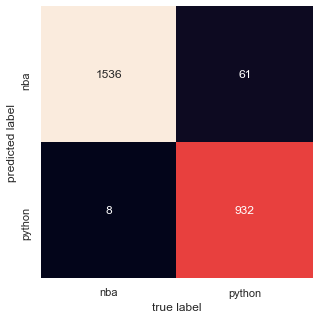

In [64]:
print("Naive Bayes: (Input: TF-IDF) \n")
nb_mod = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_mod.fit(x_train, y_train)
pred_labels = nb_mod.predict(x_test)
print("Predicted labels for test_data:", pred_labels)
# Confusion matrix
mat = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('true label')
plt.ylabel('predicted label')
print('')
# F1 scores
print("Microaveraged F1 scores:", f1_score(y_test, pred_labels, average='micro'))
print("Macroaveraged F1 scores", f1_score(y_test, pred_labels, average="macro"), '\n')
# Cross validation
print('Cross Validation: (5-fold)')
nb_tf_scores = cross_val_score(nb_mod, all_tweets, all_labels, cv=5, scoring='f1_micro')
print('Mean/SD of micro F1 scores:', nb_tf_scores.mean(), '/', nb_tf_scores.std())
scores = cross_val_score(nb_mod, all_tweets, all_labels, cv=5, scoring='f1_macro')
print('Mean/SD of macro F1 scores:', scores.mean(), '/', scores.std())

# 6. Logistic Regression

Logistic Regression: (Input: TF-IDF)

Predicted labels for test_data: ['nba' 'nba' 'python' ... 'nba' 'nba' 'nba']

Microaveraged F1 scores: 0.974773354355538
Macroaveraged F1 scores 0.973397297261872 

Cross Validation: (5-fold)
Mean/SD of micro F1 scores: 0.97693394111586 / 0.0031276819531179407
Mean/SD of macro F1 scores: 0.9758575826552148 / 0.0032958076339115175


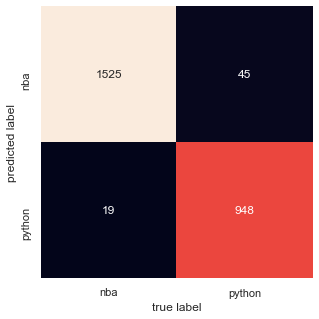

In [65]:
print("Logistic Regression: (Input: TF-IDF)\n")
lr_mod = make_pipeline(TfidfVectorizer(), LogisticRegression())
lr_mod.fit(x_train, y_train)
pred_labels = lr_mod.predict(x_test)
print("Predicted labels for test_data:", pred_labels)
# Confusion matrix
mat = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('true label')
plt.ylabel('predicted label')
print('')
# F1 scores
print("Microaveraged F1 scores:", f1_score(y_test, pred_labels, average='micro'))
print("Macroaveraged F1 scores", f1_score(y_test, pred_labels, average="macro"), '\n')
# Cross validation
print('Cross Validation: (5-fold)')
lr_tf_scores = cross_val_score(lr_mod, all_tweets, all_labels, cv=5, scoring='f1_micro')
print('Mean/SD of micro F1 scores:', lr_tf_scores.mean(), '/', lr_tf_scores.std())
scores = cross_val_score(lr_mod, all_tweets, all_labels, cv=5, scoring='f1_macro')
print('Mean/SD of macro F1 scores:', scores.mean(), '/', scores.std())

Logistic Regression: (Input: Word Embeddings)

Predicted labels for test_data: ['nba' 'nba' 'python' ... 'nba' 'nba' 'nba']

Microaveraged F1 scores: 0.9668900275916438
Macroaveraged F1 scores 0.9653126916601233

Cross Validation: (5-fold)
Mean/SD of micro F1 scores: 0.9658543545000097 / 0.0031583849684525644
Mean/SD of macro F1 scores: 0.9644111319723491 / 0.0033106951655672875


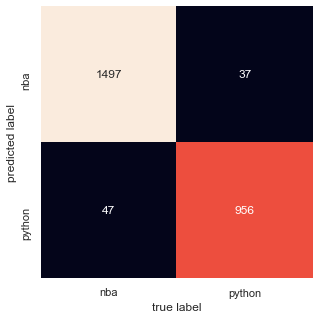

In [66]:
print("Logistic Regression: (Input: Word Embeddings)\n")
lr_mod_embed = LogisticRegression()
lr_mod_embed.fit(x_train_embed, y_train)
pred_labels = lr_mod_embed.predict(x_test_embed)
print("Predicted labels for test_data:", pred_labels)
# Confusion matrix
mat = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('true label')
plt.ylabel('predicted label')
print('')
# F1 scores
print("Microaveraged F1 scores:", f1_score(y_test, pred_labels, average='micro'))
print("Macroaveraged F1 scores", f1_score(y_test, pred_labels, average="macro"))
print('')
# Cross validation
print('Cross Validation: (5-fold)')
lr_we_scores = cross_val_score(lr_mod_embed, all_tweets_embed, all_labels, cv=5, scoring='f1_micro')
print('Mean/SD of micro F1 scores:', lr_we_scores.mean(), '/', lr_we_scores.std())
scores = cross_val_score(lr_mod_embed, all_tweets_embed, all_labels, cv=5, scoring='f1_macro')
print('Mean/SD of macro F1 scores:', scores.mean(), '/', scores.std())

# 7.  Neural Network model  from sklearn

Neural Network: (Input: TF-IDF) 

Predicted labels of x_test: ['nba' 'nba' 'python' ... 'nba' 'nba' 'nba']

Microaveraged F1 scores: 0.9862041781631848
Macroaveraged F1 scores 0.985486917631822

Cross Validation: (5-fold)
Mean/SD of micro F1 scores: 0.9869488978267453 / 0.0020698127446212955
Mean/SD of macro F1 scores: 0.9861763988424522 / 0.0022538720718211455


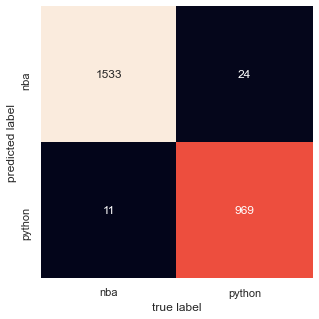

In [89]:
# One hidden layer with 50 units
print("Neural Network: (Input: TF-IDF) \n")
mlp_mod = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(50,)))
mlp_mod.fit(x_train, y_train)
pred_labels = mlp_mod.predict(x_test)
print("Predicted labels of x_test:", pred_labels)
# Confusion matrix
mat = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('true label')
plt.ylabel('predicted label')
print('')
# F1 scores
print("Microaveraged F1 scores:", f1_score(y_test, pred_labels, average='micro'))
print("Macroaveraged F1 scores", f1_score(y_test, pred_labels, average="macro"))
print('')
# Cross validation
print('Cross Validation: (5-fold)')
nn_tf_scores = cross_val_score(mlp_mod, all_tweets, all_labels, cv=5, scoring='f1_micro', n_jobs=-1)
print('Mean/SD of micro F1 scores:', nn_tf_scores.mean(), '/', nn_tf_scores.std())
scores = cross_val_score(mlp_mod, all_tweets, all_labels, cv=5, scoring='f1_macro', n_jobs=-1)
print('Mean/SD of macro F1 scores:', scores.mean(), '/', scores.std())

Neural Network: (Input: Word Embeddings)

Predicted labels of x_test: ['nba' 'nba' 'python' ... 'nba' 'nba' 'nba']

Microaveraged F1 scores: 0.9795033504138747
Macroaveraged F1 scores 0.9784731405417189

Cross Validation: (5-fold)


/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean/SD of micro F1 scores: 0.9783532973787746 / 0.0031858178576970784


/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean/SD of macro F1 scores: 0.9764035643967057 / 0.0035055118867826436


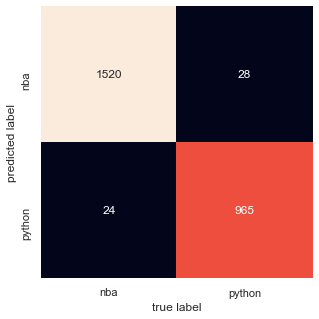

In [90]:
# One hidden layer with 50 units
print("Neural Network: (Input: Word Embeddings)\n")
mlp_mod_embed = MLPClassifier(hidden_layer_sizes=(50,))
mlp_mod_embed.fit(x_train_embed, y_train)
pred_labels = mlp_mod_embed.predict(x_test_embed)
print("Predicted labels of x_test:", pred_labels)
# Confusion matrix
mat = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('true label')
plt.ylabel('predicted label')
print('')
# F1 scores
print("Microaveraged F1 scores:", f1_score(y_test, pred_labels, average='micro'))
print("Macroaveraged F1 scores", f1_score(y_test, pred_labels, average="macro"))
print('')
# Cross validation
print('Cross Validation: (5-fold)')
nn_we_scores = cross_val_score(mlp_mod_embed, all_tweets_embed, all_labels, cv=5, scoring='f1_micro')
print('Mean/SD of micro F1 scores:', nn_we_scores.mean(), '/', nn_we_scores.std())
scores = cross_val_score(mlp_mod_embed, all_tweets_embed, all_labels, cv=5, scoring='f1_macro')
print('Mean/SD of macro F1 scores:', scores.mean(), '/', scores.std())

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


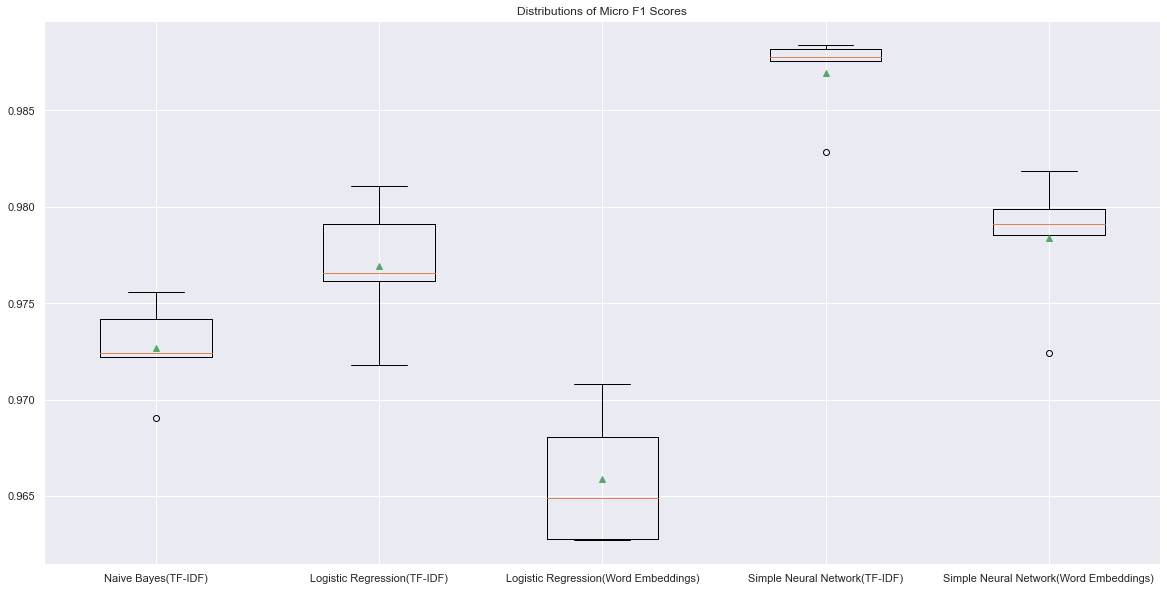

In [95]:
#Create a figure instance
fig = plt.figure(1, figsize=(20, 10))
# Create an axes instance
axes = fig.add_subplot(111)
# Create the titile and labels
labels = ['Naive Bayes(TF-IDF)', 'Logistic Regression(TF-IDF)', 'Logistic Regression(Word Embeddings)', 
          'Simple Neural Network(TF-IDF)', 'Simple Neural Network(Word Embeddings)']
axes.set_xticklabels(labels)
axes.set_title("Distributions of Micro F1 Scores")
# Create the boxplot
bp = axes.boxplot([nb_tf_scores, lr_tf_scores, lr_we_scores, nn_tf_scores, nn_we_scores], showmeans=True)